# 第6章: 日本語 DNN 音声合成システムの実装

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/r9y9/ttslearn/blob/master/notebooks/ch06_Recipe-DNNTTS.ipynb)

Google colabでの実行における推定所要時間: 1時間

このノートブックに記載のレシピの設定は、Google Colab上で実行した場合のタイムアウトを避けるため、学習条件を書籍に記載の設定から一部修正していることに注意してください (バッチサイズを減らす等)。
参考までに、書籍に記載の条件で、著者 (山本) がレシピを実行した結果を以下で公開しています。

- Tensorboard logs: https://tensorboard.dev/experiment/ajmqiymoTx6rADKLF8d6sA/
- expディレクトリ(学習済みモデル、合成音声を含む) : https://drive.google.com/file/d/171gGoH3H4PJ-9cMQES-l6KpTu9n0udGD/view?usp=sharing (12.8 MB)

## 準備

### Google Colabを利用する場合

Google Colab上でこのノートブックを実行する場合は、メニューの「ランタイム -> ランタイムのタイムの変更」から、「ハードウェア アクセラレータ」を **GPU** に変更してください。

### Python version

In [1]:
!python -VV

Python 3.7.11 (default, Jul 27 2021, 14:32:16) 
[GCC 7.5.0]


### ttslearn のインストール

In [2]:
%%capture
try:
    import ttslearn
except ImportError:
    !pip install ttslearn

In [3]:
import ttslearn
ttslearn.__version__

'0.2.2'

## 6.1 本章の日本語音声合成システムの実装

### 学習済みモデルを用いた音声合成

In [4]:
from ttslearn.dnntts import DNNTTS
from IPython.display import Audio

engine = DNNTTS()
wav, sr = engine.tts("深層学習に基づく音声合成システムです。")
Audio(wav, rate=sr)

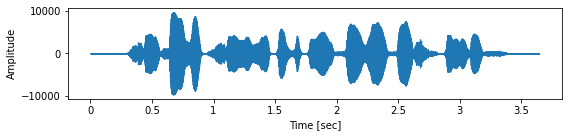

In [5]:
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 2))
librosa.display.waveshow(wav.astype(np.float32), sr=sr, ax=ax)
ax.set_xlabel("Time [sec]")
ax.set_ylabel("Amplitude")
plt.tight_layout()

### レシピ実行の前準備

In [6]:
%%capture
from ttslearn.env import is_colab
from os.path import exists

# pip install ttslearn ではレシピはインストールされないので、手動でダウンロード
if is_colab() and not exists("recipes.zip"):
    !curl -LO https://github.com/r9y9/ttslearn/releases/download/v{ttslearn.__version__}/recipes.zip
    !unzip -o recipes.zip

In [7]:
import os
# recipeのディレクトリに移動
cwd = os.getcwd()
if cwd.endswith("notebooks"):
    os.chdir("../recipes/dnntts/")
elif is_colab():
    os.chdir("recipes/dnntts/")

In [8]:
import time
start_time = time.time()

### パッケージのインポート

In [9]:
# %pylab inline
# %load_ext autoreload
# %load_ext tensorboard
# %autoreload
import IPython
from IPython.display import Audio
import tensorboard as tb
import os

In [10]:
# 数値演算
import numpy as np
import torch
from torch import nn
# 音声波形の読み込み
from scipy.io import wavfile
# フルコンテキストラベル、質問ファイルの読み込み
from nnmnkwii.io import hts
# 音声分析
import pysptk
import pyworld
# 音声分析、可視化
import librosa
import librosa.display
import pandas as pd
# Pythonで学ぶ音声合成
import ttslearn

In [11]:
# シードの固定
from ttslearn.util import init_seed
init_seed(773)

In [12]:
torch.__version__

'1.10.0'

### 描画周りの設定

In [13]:
from ttslearn.notebook import get_cmap, init_plot_style, savefig
cmap = get_cmap()
init_plot_style()

### レシピの設定

In [14]:
# run.shを利用した学習スクリプトをnotebookから行いたい場合は、True
# google colab の場合は、True とします
# ローカル環境の場合、run.sh をターミナルから実行することを推奨します。
# その場合、このノートブックは可視化・学習済みモデルのテストのために利用します。
run_sh = is_colab()

# CUDA
# NOTE: run.shの引数として渡すので、boolではなく文字列で定義しています
cudnn_benchmark = "true"
cudnn_deterministic = "false"

# 特徴抽出時の並列処理のジョブ数
n_jobs = os.cpu_count()//2

# 継続長モデルの設定ファイル名
duration_config_name="duration_dnn"
# 音響モデルの設定ファイル名
acoustic_config_name="acoustic_dnn_sr16k"

# 継続長モデル & 音響モデル学習におけるバッチサイズ
batch_size = 32
# 継続長モデル & 音響モデル学習におけるエポック数
# 注意: 計算時間を少なくするために、やや少なく設定しています。品質を向上させるためには、30 ~ 50 のエポック数を試してみてください。
nepochs = 30

# run.sh経由で実行するスクリプトのtqdm
run_sh_tqdm = "none"

In [15]:
# ノートブックで利用するテスト用の発話（学習データ、評価データ）
train_utt = "BASIC5000_0001"
test_utt = "BASIC5000_5000"

### Tensorboard によるログの可視化

In [16]:
# ノートブック上から tensorboard のログを確認する場合、次の行を有効にしてください
if is_colab():
    %tensorboard --logdir tensorboard/

## 6.2 プログラム実装の前準備

### stage -1: コーパスのダウンロード

In [17]:
if is_colab():
    ! ./run.sh --stage -1 --stop-stage -1

### Stage 0: 学習/検証/評価データの分割

In [18]:
!pwd

/home/vscode/workspaces/ttslearn/recipes/dnntts


In [19]:
if run_sh:
    ! ./run.sh --stage 0 --stop-stage 0

In [20]:
! ls data/

dev.list  eval.list  train.list  utt_list.txt


In [21]:
! head data/dev.list

BASIC5000_4574
BASIC5000_4575
BASIC5000_4576
BASIC5000_4578
BASIC5000_4579
BASIC5000_4580
BASIC5000_4582
BASIC5000_4583
BASIC5000_4584
BASIC5000_4585


## 6.3 継続長モデルのための前処理

### 継続長モデルのための1発話に対する前処理

In [22]:
import ttslearn
from nnmnkwii.io import hts
from nnmnkwii.frontend import merlin as fe

# 言語特徴量の抽出に使うための質問ファイル
binary_dict, numeric_dict = hts.load_question_set(ttslearn.util.example_qst_file())

# 音声のフルコンテキストラベルを読み込む
labels = hts.load(ttslearn.util.example_label_file())

# 継続長モデルの入力：言語特徴量
in_feats = fe.linguistic_features(labels, binary_dict, numeric_dict)

# 継続長モデルの出力：音素継続長
out_feats = fe.duration_features(labels)

In [23]:
print("入力特徴量のサイズ:", in_feats.shape)
print("出力特徴量のサイズ:", out_feats.shape)

入力特徴量のサイズ: (44, 325)
出力特徴量のサイズ: (44, 1)


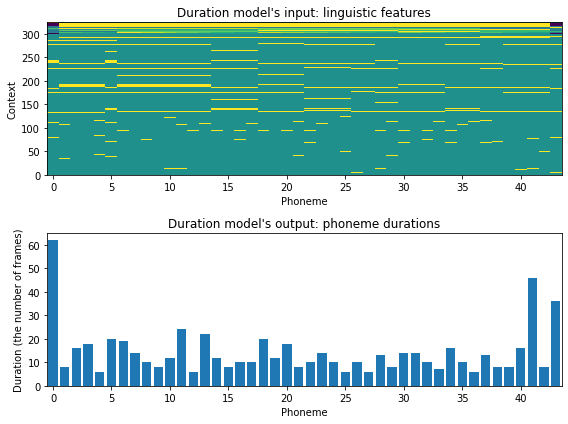

In [24]:
# 可視化用に正規化
in_feats_norm = in_feats / np.maximum(1, np.abs(in_feats).max(0))
fig, ax = plt.subplots(2, 1, figsize=(8,6))
ax[0].set_title("Duration model's input: linguistic features")
ax[1].set_title("Duration model's output: phoneme durations")
ax[0].imshow(in_feats_norm.T, aspect="auto", interpolation="nearest", origin="lower", cmap=cmap)
ax[0].set_ylabel("Context")

ax[1].bar(np.arange(len(out_feats)), out_feats.reshape(-1))

for a in ax:
    a.set_xlim(-0.5, len(in_feats)-0.5)
    a.set_xlabel("Phoneme")
ax[1].set_ylabel("Duration (the number of frames)")
plt.tight_layout()

# 図6-3
savefig("fig/dnntts_impl_duration_inout")

### レシピの stage 1 の実行

バッチ処理を行うコマンドラインプログラムは、 `preprocess_duration.py` を参照してください。

In [25]:
if run_sh:
    ! ./run.sh --stage 1 --stop-stage 1 --n-jobs $n_jobs 

## 6.4: 音響モデルのための前処理

### 音響モデルのための 1 発話に対する前処理

In [26]:
from ttslearn.dsp import world_spss_params

# 言語特徴量の抽出に使うための質問ファイル
binary_dict, numeric_dict = hts.load_question_set(ttslearn.util.example_qst_file())

# 音声のフルコンテキストラベルを読み込む
labels = hts.load(ttslearn.util.example_label_file())

# 音響モデルの入力：言語特徴量
in_feats = fe.linguistic_features(
    labels,
    binary_dict,
    numeric_dict,
    add_frame_features=True,
    subphone_features="coarse_coding",
)

# 音声の読み込み
_sr, x = wavfile.read(ttslearn.util.example_audio_file())
sr = 16000
x = (x / 32768).astype(np.float64)
x = librosa.resample(x, orig_sr=_sr, target_sr=sr)

# 音響モデルの出力：音響特徴量
out_feats = world_spss_params(x, sr)

print(f"調整前の長さ: infeats {in_feats.shape} , out_feats {out_feats.shape}")

# フレーム数の調整
minL = min(in_feats.shape[0], out_feats.shape[0])
in_feats, out_feats = in_feats[:minL], out_feats[:minL]

# 冒頭と末尾の非音声区間の長さを調整
assert "sil" in labels.contexts[0] and "sil" in labels.contexts[-1]
start_frame = int(labels.start_times[1] / 50000)
end_frame = int(labels.end_times[-2] / 50000)

# 冒頭：50 ミリ秒、末尾：100 ミリ秒
start_frame = max(0, start_frame - int(0.050 / 0.005))
end_frame = min(minL, end_frame + int(0.100 / 0.005))

in_feats = in_feats[start_frame:end_frame]
out_feats = out_feats[start_frame:end_frame]

調整前の長さ: infeats (636, 329) , out_feats (639, 127)


In [27]:
print("入力特徴量のサイズ:", in_feats.shape)
print("出力特徴量のサイズ:", out_feats.shape)

入力特徴量のサイズ: (568, 329)
出力特徴量のサイズ: (568, 127)


#### 音響特徴量を分離して確認

In [28]:
from ttslearn.dnntts.multistream import get_static_features

sr = 16000
hop_length = int(sr * 0.005)
alpha = pysptk.util.mcepalpha(sr)
fft_size = pyworld.get_cheaptrick_fft_size(sr)

# 動的特徴量を除いて、各音響特徴量を取り出します
mgc, lf0, vuv, bap = get_static_features(
    out_feats, num_windows=3, stream_sizes=[120, 3, 1, 3],
    has_dynamic_features=[True, True, False, True]) 
print("メルケプストラムのサイズ:", mgc.shape)
print("連続対数基本周波数のサイズ:", lf0.shape)
print("有声/無声フラグのサイズ:", vuv.shape)
print("帯域非周期性指標のサイズ:", bap.shape)

メルケプストラムのサイズ: (568, 40)
連続対数基本周波数のサイズ: (568, 1)
有声/無声フラグのサイズ: (568, 1)
帯域非周期性指標のサイズ: (568, 1)


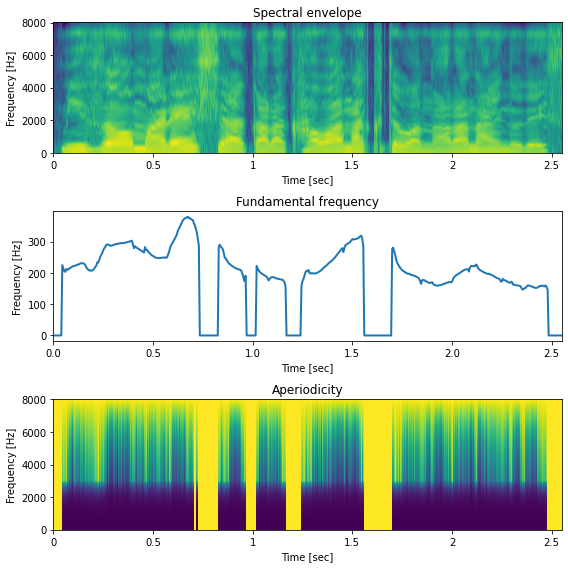

In [29]:
def vis_out_feats(mgc, lf0, vuv, bap):
    fig, ax = plt.subplots(3, 1, figsize=(8,8))
    ax[0].set_title("Spectral envelope")
    ax[1].set_title("Fundamental frequency")
    ax[2].set_title("Aperiodicity")
    
    logsp = np.log(pysptk.mc2sp(mgc, alpha, fft_size))
    librosa.display.specshow(logsp.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="hz", cmap=cmap, ax=ax[0])
    
    timeaxis = np.arange(len(lf0)) * 0.005
    f0 = np.exp(lf0)
    f0[vuv < 0.5] = 0
    ax[1].plot(timeaxis, f0, linewidth=2)
    ax[1].set_xlim(0, len(f0)*0.005)

    aperiodicity = pyworld.decode_aperiodicity(bap.astype(np.float64), sr, fft_size)
    librosa.display.specshow(aperiodicity.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="hz", cmap=cmap, ax=ax[2])
    
    for a in ax:
        a.set_xlabel("Time [sec]")
        a.set_ylabel("Frequency [Hz]")
        # 末尾の非音声区間を除く
        a.set_xlim(0, 2.55)
    
    plt.tight_layout()

# 音響特徴量の可視化
vis_out_feats(mgc, lf0, vuv, bap)
# 図6-4
savefig("./fig/dnntts_impl_acoustic_out_feats")

#### 音響モデルの入力と出力の可視化

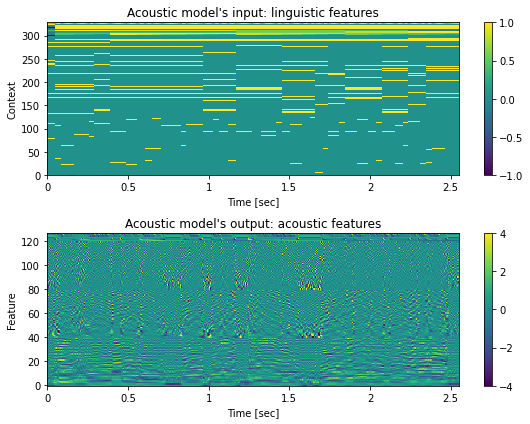

In [30]:
# 可視化用に正規化
from scipy.stats import zscore 

in_feats_norm = in_feats / np.maximum(1, np.abs(in_feats).max(0))
out_feats_norm = zscore(out_feats)

fig, ax = plt.subplots(2, 1, figsize=(8,6))
ax[0].set_title("Acoustic model's input: linguistic features")
ax[1].set_title("Acoustic model's output: acoustic features")
mesh = librosa.display.specshow(
    in_feats_norm.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="frames", ax=ax[0], cmap=cmap)
fig.colorbar(mesh, ax=ax[0])
mesh = librosa.display.specshow(
    out_feats_norm.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="frames",ax=ax[1], cmap=cmap)
# NOTE: 実際には [-4, 4]の範囲外の値もありますが、視認性のために [-4, 4]に設定します
mesh.set_clim(-4, 4)
fig.colorbar(mesh, ax=ax[1])

ax[0].set_ylabel("Context")
ax[1].set_ylabel("Feature")

for a in ax:
    a.set_xlabel("Time [sec]")
    # 末尾の非音声区間を除く
    a.set_xlim(0, 2.55)
    
plt.tight_layout()

### レシピの stage 2 の実行

バッチ処理を行うコマンドラインプログラムは、 `preprocess_acoustic.py` を参照してください。

In [31]:
if run_sh:
    ! ./run.sh --stage 2 --stop-stage 2 --n-jobs $n_jobs

## 6.5 特徴量の正規化

正規化のための統計量を計算するコマンドラインプログラムは、 `recipes/common/fit_scaler.py` を参照してください。また、正規化を行うコマンドラインプログラムは、 `recipes/common/preprocess_normalize.py` を参照してください。

### レシピの stage 3 の実行

In [32]:
if run_sh:
    ! ./run.sh --stage 3 --stop-stage 3 --n-jobs $n_jobs

### 正規化の処理の結果の確認

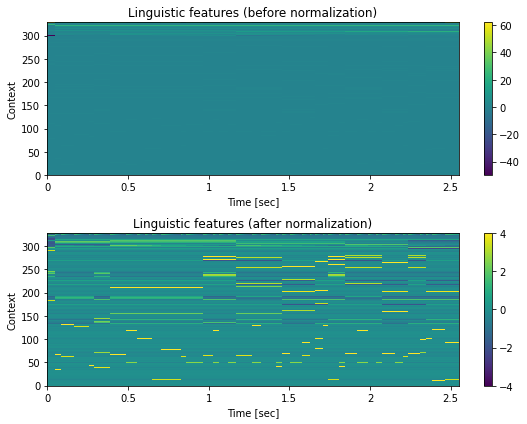

In [33]:
# 言語特徴量の正規化前後
in_feats = np.load(f"dump/jsut_sr16000/org/train/in_acoustic/{train_utt}-feats.npy")
in_feats_norm = np.load(f"dump/jsut_sr16000/norm/train/in_acoustic/{train_utt}-feats.npy")
fig, ax = plt.subplots(2, 1, figsize=(8,6))
ax[0].set_title("Linguistic features (before normalization)")
ax[1].set_title("Linguistic features (after normalization)")
mesh = librosa.display.specshow(
    in_feats.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="frames", ax=ax[0], cmap=cmap)
fig.colorbar(mesh, ax=ax[0])
mesh = librosa.display.specshow(
    in_feats_norm.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="frames",ax=ax[1], cmap=cmap)
# NOTE: 実際には [-4, 4]の範囲外の値もありますが、視認性のために [-4, 4]に設定します
mesh.set_clim(-4, 4)
fig.colorbar(mesh, ax=ax[1])

for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Context")
    # 末尾の非音声区間を除く
    a.set_xlim(0, 2.55) 
plt.tight_layout()
# 図6-5
savefig("./fig/dnntts_impl_in_feats_norm")

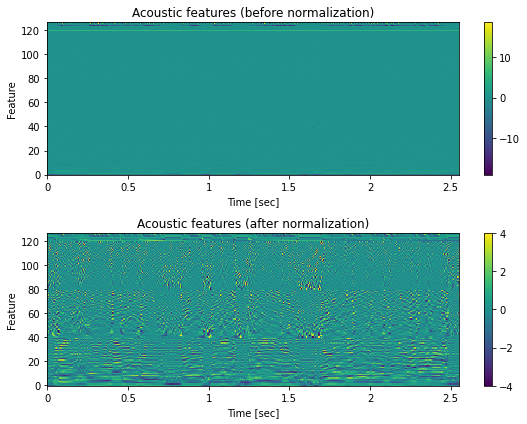

In [34]:
# 音響特徴量の正規化前後
out_feats = np.load(f"dump/jsut_sr16000/org/train/out_acoustic/{train_utt}-feats.npy")
out_feats_norm = np.load(f"dump/jsut_sr16000/norm/train/out_acoustic/{train_utt}-feats.npy")
fig, ax = plt.subplots(2, 1, figsize=(8,6))
ax[0].set_title("Acoustic features (before normalization)")
ax[1].set_title("Acoustic features (after normalization)")
mesh = librosa.display.specshow(
    out_feats.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="frames", ax=ax[0], cmap=cmap)
fig.colorbar(mesh, ax=ax[0])
mesh = librosa.display.specshow(
    out_feats_norm.T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="frames",ax=ax[1], cmap=cmap)
# NOTE: 実際には [-4, 4]の範囲外の値もありますが、視認性のために [-4, 4]に設定します
mesh.set_clim(-4, 4)
fig.colorbar(mesh, ax=ax[1])

for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Feature")
    # 末尾の非音声区間を除く
    a.set_xlim(0, 2.55)
plt.tight_layout()

## 6.6 ニューラルネットワークの実装

### 全結合型ニューラルネットワーク

In [35]:
class DNN(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_layers=2):
        super(DNN, self).__init__()
        model = [nn.Linear(in_dim, hidden_dim), nn.ReLU()]
        for _ in range(num_layers):
            model.append(nn.Linear(hidden_dim, hidden_dim))
            model.append(nn.ReLU())
        model.append(nn.Linear(hidden_dim, out_dim))
        self.model = nn.Sequential(*model)

    def forward(self, x, lens=None):
        return self.model(x)

In [36]:
DNN(in_dim=325, hidden_dim=64, out_dim=1, num_layers=2)

DNN(
  (model): Sequential(
    (0): Linear(in_features=325, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

### LSTM-RNN

In [37]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class LSTMRNN(nn.Module):
    def __init__(
        self, in_dim, hidden_dim, out_dim, num_layers=1, bidirectional=True, dropout=0.0
    ):
        super(LSTMRNN, self).__init__()
        self.num_layers = num_layers
        num_direction = 2 if bidirectional else 1
        self.lstm = nn.LSTM(
            in_dim,
            hidden_dim,
            num_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=dropout,
        )
        self.hidden2out = nn.Linear(num_direction * hidden_dim, out_dim)

    def forward(self, seqs, lens):
        seqs = pack_padded_sequence(seqs, lens, batch_first=True)
        out, _ = self.lstm(seqs)
        out, _ = pad_packed_sequence(out, batch_first=True)
        out = self.hidden2out(out)
        return out

In [38]:
LSTMRNN(in_dim=325, hidden_dim=64, out_dim=1, num_layers=2)

LSTMRNN(
  (lstm): LSTM(325, 64, num_layers=2, batch_first=True, bidirectional=True)
  (hidden2out): Linear(in_features=128, out_features=1, bias=True)
)

## 6.7 学習スクリプトの実装

### DataLoader の実装

#### Datasetクラスの定義

In [39]:
from torch.utils import data as data_utils

class Dataset(data_utils.Dataset):
    def __init__(self, in_paths, out_paths):
        self.in_paths = in_paths
        self.out_paths = out_paths

    def __getitem__(self, idx):
        return np.load(self.in_paths[idx]), np.load(self.out_paths[idx])

    def __len__(self):
        return len(self.in_paths)

#### DataLoader の利用例

In [40]:
from pathlib import Path
from ttslearn.util import pad_2d

def collate_fn_dnntts(batch):
    lengths = [len(x[0]) for x in batch]
    max_len = max(lengths)
    x_batch = torch.stack([torch.from_numpy(pad_2d(x[0], max_len)) for x in batch])
    y_batch = torch.stack([torch.from_numpy(pad_2d(x[1], max_len)) for x in batch])
    lengths = torch.tensor(lengths, dtype=torch.long)
    return x_batch, y_batch, lengths


in_paths = sorted(Path("./dump/jsut_sr16000/norm/dev/in_duration/").glob("*.npy"))
out_paths = sorted(Path("./dump/jsut_sr16000/norm/dev/out_duration/").glob("*.npy"))

dataset = Dataset(in_paths, out_paths)
data_loader = data_utils.DataLoader(dataset, batch_size=8, collate_fn=collate_fn_dnntts, num_workers=0)

in_feats, out_feats, lengths = next(iter(data_loader))

print("入力特徴量のサイズ:", tuple(in_feats.shape))
print("出力特徴量のサイズ:", tuple(out_feats.shape))
print("系列長のサイズ:", tuple(lengths.shape))

入力特徴量のサイズ: (8, 86, 325)
出力特徴量のサイズ: (8, 86, 1)
系列長のサイズ: (8,)


#### ミニバッチの可視化

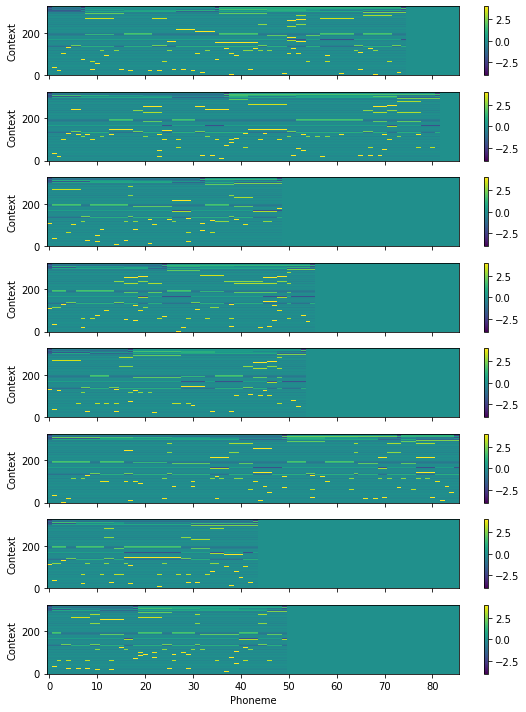

In [41]:
fig, ax = plt.subplots(len(in_feats), 1, figsize=(8,10), sharex=True, sharey=True)
for n in range(len(in_feats)):
    x = in_feats[n].data.numpy()
    mesh = ax[n].imshow(x.T, aspect="auto", interpolation="nearest", origin="lower", cmap=cmap)
    fig.colorbar(mesh, ax=ax[n])
    # NOTE: 実際には [-4, 4]の範囲外の値もありますが、視認性のために [-4, 4]に設定します
    mesh.set_clim(-4, 4)
    
ax[-1].set_xlabel("Phoneme")
for a in ax:
    a.set_ylabel("Context")
plt.tight_layout()

# 図6-6
savefig("fig/dnntts_impl_minibatch")

### 学習の前準備

In [42]:
from ttslearn.dnntts import DNN
from torch import optim

model = DNN(in_dim=325, hidden_dim=64, out_dim=1, num_layers=2)

# lr は学習率を表します
optimizer = optim.Adam(model.parameters(), lr=0.01)

# gamma は学習率の減衰係数を表します
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=10)

### 学習ループの実装

In [43]:
# DataLoader を用いたミニバッチの作成: ミニバッチ毎に処理する
for in_feats, out_feats, lengths in data_loader:
    # 順伝播の計算
    pred_out_feats = model(in_feats, lengths)
    # 損失の計算
    loss = nn.MSELoss()(pred_out_feats, out_feats)
    # 損失の値を出力
    print(loss.item())
    # optimizer に蓄積された勾配をリセット
    optimizer.zero_grad()
    # 誤差の逆伝播の計算
    loss.backward()
    # パラメータの更新
    optimizer.step()

0.5847609043121338
0.6096929907798767
0.7466080784797668
0.2730913460254669
0.44654127955436707
0.2554619014263153
0.27791279554367065
0.5924186706542969
0.2424875795841217
0.40172719955444336
0.18745970726013184
0.16529332101345062
0.21711347997188568
0.20858852565288544
0.1573624163866043
0.16600747406482697
0.24657703936100006
0.16559934616088867
0.13827230036258698
0.3043403625488281
0.4748716354370117
1.1685540676116943
0.1996913105249405
0.24324041604995728
0.29316413402557373


### hydra を用いたコマンドラインプログラムの実装

`hydra/hydra_quick_start` と `hydra/hydra_composision` を参照してください。

### hydra を用いた実用的な学習スクリプトの設定ファイル

`conf/train_dnntts` ディレクトリを参照してください

In [44]:
! cat conf/train_dnntts/config.yaml

# @package _global_

defaults:
  - model: duration_dnn

verbose: 100
seed: 773

# 1) none 2) tqdm
tqdm: tqdm

cudnn:
  benchmark: true
  deterministic: false

# Multi-gpu
data_parallel: false

###########################################################
#                DATA SETTING                             #
###########################################################
data:
  # training set
  train:
    utt_list: data/train.list
    in_dir:
    out_dir:

  # development set
  dev:
    utt_list: data/dev.list
    in_dir:
    out_dir:

  # data loader
  num_workers: 4
  batch_size: 32

###########################################################
#                TRAIN SETTING                            #
###########################################################
train:
  out_dir: exp
  log_dir: tensorboard/exp

  max_train_steps: -1
  nepochs: 30
  checkpoint_epoch_interval: 10

  optim:
    optimizer:
      name: Adam
      params:
        lr: 0.001
        betas: [0.9, 0.999]
       

### hydra を用いた実用的な学習スクリプトの実装

`train_dnntts.py` を参照してください。

## 6.8 継続長モデルの学習

### 継続長モデルの設定ファイル

In [45]:
! cat conf/train_dnntts/model/{duration_config_name}.yaml

netG:
  _target_: ttslearn.dnntts.DNN
  in_dim: 325
  out_dim: 1
  hidden_dim: 64
  num_layers: 2

stream_sizes: [1]
has_dynamic_features: [false]


### 継続長モデルのインスタンス化

In [46]:
import hydra
from omegaconf import OmegaConf
hydra.utils.instantiate(OmegaConf.load(f"conf/train_dnntts/model/{duration_config_name}.yaml").netG)

DNN(
  (model): Sequential(
    (0): Linear(in_features=325, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)

### レシピの stage 4 の実行

In [47]:
if run_sh:
    ! ./run.sh --stage 4 --stop-stage 4 --duration-model $duration_config_name \
    --tqdm $run_sh_tqdm --dnntts-data-batch-size $batch_size --dnntts-train-nepochs $nepochs \
    --cudnn-benchmark $cudnn_benchmark --cudnn-deterministic $cudnn_deterministic

### 損失関数の値の推移

著者による実験結果です。Tensorboardのログは https://tensorboard.dev/ にアップロードされています。
ログデータを`tensorboard` パッケージを利用してダウンロードします。

https://tensorboard.dev/experiment/ajmqiymoTx6rADKLF8d6sA/

In [48]:
if exists("tensorboard/all_log.csv"):
    df = pd.read_csv("tensorboard/all_log.csv")
else:
    experiment_id = "ajmqiymoTx6rADKLF8d6sA"
    experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
    df = experiment.get_scalars(pivot=True) 
    df.to_csv("tensorboard/all_log.csv", index=False)
df["run"].unique()

ValueError: Error [from server]: 
****************************************************************
****************************************************************
****************************************************************

ERROR: TensorBoard.dev has been shut down.

This command is no longer operational and will be removed.

See the FAQ at https://tensorboard.dev.

****************************************************************
****************************************************************
****************************************************************


In [49]:
duration_loss = df[df.run.str.contains("duration")]

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(duration_loss["step"], duration_loss["Loss/train"], label="Train")
ax.plot(duration_loss["step"], duration_loss["Loss/dev"], "--", label="Dev")
ax.set_xlabel("Epoch")
ax.set_ylabel("Epoch loss")
plt.legend()

# 図6-8
savefig("fig/dnntts_impl_duration_dnn_loss")

NameError: name 'df' is not defined

## 6.9 音響モデルの学習

### 音響モデルの設定ファイル

In [50]:
! cat conf/train_dnntts/model/{acoustic_config_name}.yaml

netG:
  _target_: ttslearn.dnntts.DNN
  in_dim: 329
  out_dim: 127
  hidden_dim: 256
  num_layers: 2

# (mgc, lf0, vuv, bap)
stream_sizes: [120, 3, 1, 3]
has_dynamic_features: [true, true, false, true]
num_windows: 3


### 音響モデルのインスタンス化

In [ ]:
import hydra
from omegaconf import OmegaConf
hydra.utils.instantiate(OmegaConf.load(f"conf/train_dnntts/model/{acoustic_config_name}.yaml").netG)

### レシピの stage 5 の実行

In [ ]:
if run_sh:
    ! ./run.sh --stage 5 --stop-stage 5 --acoustic-model $acoustic_config_name \
    --tqdm $run_sh_tqdm --dnntts-data-batch-size $batch_size --dnntts-train-nepochs $nepochs \
    --cudnn-benchmark $cudnn_benchmark --cudnn-deterministic $cudnn_deterministic

### 損失関数の値の推移

In [ ]:
acoustic_loss = df[df.run.str.contains("acoustic")]

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(acoustic_loss["step"], acoustic_loss["Loss/train"], label="Train")
ax.plot(acoustic_loss["step"], acoustic_loss["Loss/dev"], "--", label="Dev")
ax.set_xlabel("Epoch")
ax.set_ylabel("Epoch loss")

plt.legend()

# 図6-9
savefig("fig/dnntts_impl_acoustic_dnn_loss")

## 6.10 学習済みモデルを用いてテキストから音声を合成

### 学習済みモデルの読み込み

In [51]:
import joblib
device = torch.device("cpu")

#### 継続長モデルの読み込み

In [52]:
duration_config = OmegaConf.load(f"exp/jsut_sr16000/{duration_config_name}/model.yaml")
duration_model = hydra.utils.instantiate(duration_config.netG)
checkpoint = torch.load(f"exp/jsut_sr16000/{duration_config_name}/latest.pth", map_location=device)
duration_model.load_state_dict(checkpoint["state_dict"])
duration_model.eval();

#### 音響モデルの読み込み

In [53]:
acoustic_config = OmegaConf.load(f"exp/jsut_sr16000/{acoustic_config_name}/model.yaml")
acoustic_model = hydra.utils.instantiate(acoustic_config.netG)
checkpoint = torch.load(f"exp/jsut_sr16000/{acoustic_config_name}/latest.pth", map_location=device)
acoustic_model.load_state_dict(checkpoint["state_dict"])
acoustic_model.eval();

#### 統計量の読み込み

In [54]:
duration_in_scaler = joblib.load("./dump/jsut_sr16000/norm/in_duration_scaler.joblib")
duration_out_scaler = joblib.load("./dump/jsut_sr16000/norm/out_duration_scaler.joblib")
acoustic_in_scaler = joblib.load("./dump/jsut_sr16000/norm/in_acoustic_scaler.joblib")
acoustic_out_scaler = joblib.load("./dump/jsut_sr16000/norm/out_acoustic_scaler.joblib")

### 音素継続長の予測

In [55]:
@torch.no_grad()
def predict_duration(
    device,  # cpu or cuda
    labels,  # フルコンテキストラベル
    duration_model,  # 学習済み継続長モデル
    duration_config,  # 継続長モデルの設定
    duration_in_scaler,  # 言語特徴量の正規化用 StandardScaler
    duration_out_scaler,  # 音素継続長の正規化用 StandardScaler
    binary_dict,  # 二値特徴量を抽出する正規表現
    numeric_dict,  # 数値特徴量を抽出する正規表現
):
    # 言語特徴量の抽出
    in_feats = fe.linguistic_features(labels, binary_dict, numeric_dict).astype(np.float32)

    # 言語特徴量の正規化
    in_feats = duration_in_scaler.transform(in_feats)

    # 継続長の予測
    x = torch.from_numpy(in_feats).float().to(device).view(1, -1, in_feats.shape[-1])
    pred_durations = duration_model(x, [x.shape[1]]).squeeze(0).cpu().data.numpy()

    # 予測された継続長に対して、正規化の逆変換を行います
    pred_durations = duration_out_scaler.inverse_transform(pred_durations)

    # 閾値処理
    pred_durations[pred_durations <= 0] = 1
    pred_durations = np.round(pred_durations)

    return pred_durations

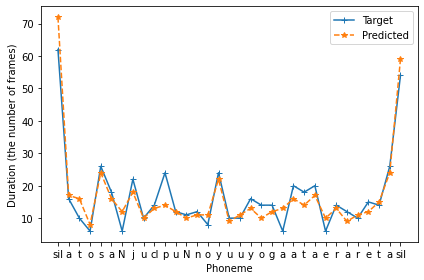

In [56]:
from ttslearn.util import lab2phonemes, find_lab, find_feats

labels = hts.load(find_lab("downloads/jsut_ver1.1/", test_utt))

# フルコンテキストラベルから音素のみを抽出
test_phonemes = lab2phonemes(labels)

# 言語特徴量の抽出に使うための質問ファイル
binary_dict, numeric_dict = hts.load_question_set(ttslearn.util.example_qst_file())

# 音素継続長の予測
durations_test = predict_duration(
    device, labels, duration_model, duration_config, duration_in_scaler, duration_out_scaler,
    binary_dict, numeric_dict)
durations_test_target = np.load(find_feats("dump/jsut_sr16000/org", test_utt, typ="out_duration"))

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(durations_test_target, "-+", label="Target")
ax.plot(durations_test, "--*", label="Predicted")
ax.set_xticks(np.arange(len(test_phonemes)))
ax.set_xticklabels(test_phonemes)
ax.set_xlabel("Phoneme")
ax.set_ylabel("Duration (the number of frames)")
ax.legend()

plt.tight_layout()

# 図6-10
savefig("fig/dnntts_impl_duration_comp")

### 音響特徴量の予測

In [57]:
from ttslearn.dnntts.multistream import get_windows, multi_stream_mlpg

@torch.no_grad()
def predict_acoustic(
    device,  # CPU or GPU
    labels,  # フルコンテキストラベル
    acoustic_model,  # 学習済み音響モデル
    acoustic_config,  # 音響モデルの設定
    acoustic_in_scaler,  # 言語特徴量の正規化用 StandardScaler
    acoustic_out_scaler,  # 音響特徴量の正規化用 StandardScaler
    binary_dict,  # 二値特徴量を抽出する正規表現
    numeric_dict,  # 数値特徴量を抽出する正規表現
    mlpg=True,  # MLPG を使用するかどうか
):
    # フレーム単位の言語特徴量の抽出
    in_feats = fe.linguistic_features(
        labels,
        binary_dict,
        numeric_dict,
        add_frame_features=True,
        subphone_features="coarse_coding",
    )
    # 正規化
    in_feats = acoustic_in_scaler.transform(in_feats)

    # 音響特徴量の予測
    x = torch.from_numpy(in_feats).float().to(device).view(1, -1, in_feats.shape[-1])
    pred_acoustic = acoustic_model(x, [x.shape[1]]).squeeze(0).cpu().data.numpy()

    # 予測された音響特徴量に対して、正規化の逆変換を行います
    pred_acoustic = acoustic_out_scaler.inverse_transform(pred_acoustic)

    # パラメータ生成アルゴリズム (MLPG) の実行
    if mlpg and np.any(acoustic_config.has_dynamic_features):
        # (T, D_out) -> (T, static_dim)
        pred_acoustic = multi_stream_mlpg(
            pred_acoustic,
            acoustic_out_scaler.var_,
            get_windows(acoustic_config.num_windows),
            acoustic_config.stream_sizes,
            acoustic_config.has_dynamic_features,
        )

    return pred_acoustic

In [58]:
labels = hts.load(f"./downloads/jsut_ver1.1/basic5000/lab/{test_utt}.lab")

# 音響特徴量の予測
out_feats = predict_acoustic(
    device, labels, acoustic_model, acoustic_config, acoustic_in_scaler,
    acoustic_out_scaler, binary_dict, numeric_dict)

In [59]:
from ttslearn.util import trim_silence
from ttslearn.dnntts.multistream import split_streams

# 特徴量は、前処理で冒頭と末尾に非音声区間が切り詰められているので、比較のためにここでも同様の処理を行います
out_feats = trim_silence(out_feats, labels)
# 結合された特徴量を分離
mgc_gen, lf0_gen, vuv_gen, bap_gen = split_streams(out_feats, [40, 1, 1, 1])

In [60]:
# 比較用に、自然音声から抽出された音響特徴量を読み込みむ
feats = np.load(f"./dump/jsut_sr16000/org/eval/out_acoustic/{test_utt}-feats.npy")
# 特徴量の分離
mgc_ref, lf0_ref, vuv_ref, bap_ref = get_static_features(
    feats, acoustic_config.num_windows, acoustic_config.stream_sizes, acoustic_config.has_dynamic_features)

#### スペクトル包絡の可視化

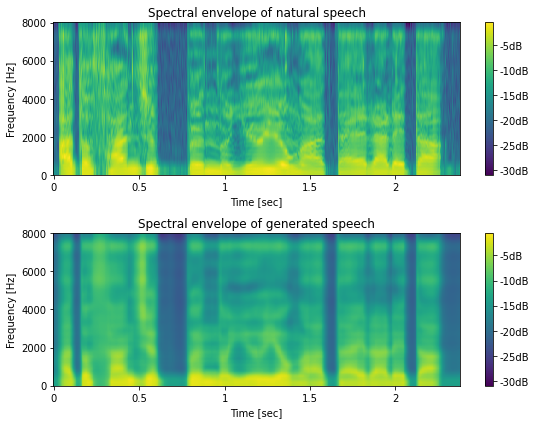

In [61]:
# 音響特徴量を、WORLDの音声パラメータへ変換する

# メルケプストラムからスペクトル包絡への変換
sp_gen= pysptk.mc2sp(mgc_gen, alpha, fft_size)
sp_ref= pysptk.mc2sp(mgc_ref, alpha, fft_size)

mindb = min(np.log(sp_ref).min(), np.log(sp_gen).min())
maxdb = max(np.log(sp_ref).max(), np.log(sp_gen).max())

fig, ax = plt.subplots(2, 1, figsize=(8,6))
mesh = librosa.display.specshow(np.log(sp_ref).T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="linear", cmap=cmap, ax=ax[0])
mesh.set_clim(mindb, maxdb)
fig.colorbar(mesh, ax=ax[0], format="%+2.fdB")
mesh = librosa.display.specshow(np.log(sp_gen).T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="linear", cmap=cmap, ax=ax[1])
mesh.set_clim(mindb, maxdb)
fig.colorbar(mesh, ax=ax[1], format="%+2.fdB")
for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Frequency [Hz]")
    
ax[0].set_title("Spectral envelope of natural speech")
ax[1].set_title("Spectral envelope of generated speech")

plt.tight_layout()

# 図6-11
savefig("./fig/dnntts_impl_spec_comp")

#### F0の可視化

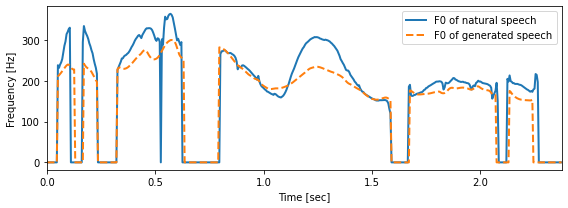

In [62]:
# 対数基本周波数から基本周波数への変換
f0_ref = np.exp(lf0_ref)
f0_ref[vuv_ref < 0.5] = 0
f0_gen = np.exp(lf0_gen)
f0_gen[vuv_gen < 0.5] = 0

timeaxis = librosa.frames_to_time(np.arange(len(f0_ref)), sr=sr, hop_length=int(0.005 * sr))

fix, ax = plt.subplots(1,1, figsize=(8,3))
ax.plot(timeaxis, f0_ref, linewidth=2, label="F0 of natural speech")
ax.plot(timeaxis, f0_gen, "--", linewidth=2, label="F0 of generated speech")

ax.set_xlabel("Time [sec]")
ax.set_ylabel("Frequency [Hz]")
ax.set_xlim(timeaxis[0], timeaxis[-1])

plt.legend()
plt.tight_layout()

# 図6-12
savefig("./fig/dnntts_impl_f0_comp")

#### 帯域非周期性指標の可視化 (bonus)

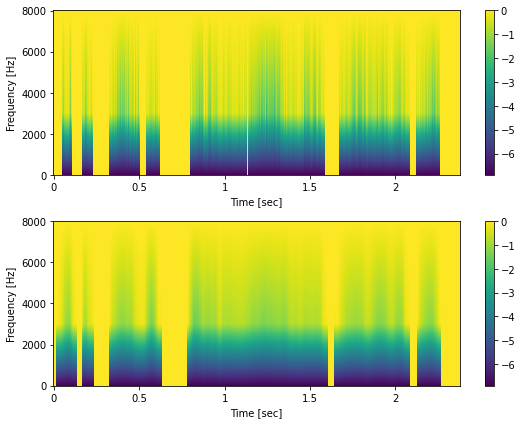

In [63]:
# 帯域非周期性指標
ap_ref = pyworld.decode_aperiodicity(bap_ref.astype(np.float64), sr, fft_size)
ap_gen = pyworld.decode_aperiodicity(bap_gen.astype(np.float64), sr, fft_size)

mindb = min(np.log(ap_ref).min(), np.log(ap_gen).min())
maxdb = max(np.log(ap_ref).max(), np.log(ap_gen).max())

fig, ax = plt.subplots(2, 1, figsize=(8,6))
mesh = librosa.display.specshow(np.log(ap_ref).T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="linear", cmap=cmap, ax=ax[0])
mesh.set_clim(mindb, maxdb)
fig.colorbar(mesh, ax=ax[0])
mesh = librosa.display.specshow(np.log(ap_gen).T, sr=sr, hop_length=hop_length, x_axis="time", y_axis="linear", cmap=cmap, ax=ax[1])
mesh.set_clim(mindb, maxdb)
fig.colorbar(mesh, ax=ax[1])

for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Frequency [Hz]")
plt.tight_layout()

### 音声波形の生成

In [64]:
from nnmnkwii.postfilters import merlin_post_filter
from ttslearn.dnntts.multistream import get_static_stream_sizes

def gen_waveform(
    sample_rate,  # サンプリング周波数
    acoustic_features,  # 音響特徴量
    stream_sizes,  # ストリームサイズ
    has_dynamic_features,  # 音響特徴量が動的特徴量を含むかどうか
    num_windows=3,  # 動的特徴量の計算に使う窓数
    post_filter=False,  # フォルマント強調のポストフィルタを使うかどうか
):
    # 静的特徴量の次元数を取得
    if np.any(has_dynamic_features):
        static_stream_sizes = get_static_stream_sizes(
            stream_sizes, has_dynamic_features, num_windows
        )
    else:
        static_stream_sizes = stream_sizes

    # 結合された音響特徴量をストリーム毎に分離
    mgc, lf0, vuv, bap = split_streams(acoustic_features, static_stream_sizes)

    fftlen = pyworld.get_cheaptrick_fft_size(sample_rate)
    alpha = pysptk.util.mcepalpha(sample_rate)

    # フォルマント強調のポストフィルタ
    if post_filter:
        mgc = merlin_post_filter(mgc, alpha)

    # 音響特徴量を音声パラメータに変換
    spectrogram = pysptk.mc2sp(mgc, fftlen=fftlen, alpha=alpha)
    aperiodicity = pyworld.decode_aperiodicity(
        bap.astype(np.float64), sample_rate, fftlen
    )
    f0 = lf0.copy()
    f0[vuv < 0.5] = 0
    f0[np.nonzero(f0)] = np.exp(f0[np.nonzero(f0)])

    # WORLD ボコーダを利用して音声生成
    gen_wav = pyworld.synthesize(
        f0.flatten().astype(np.float64),
        spectrogram.astype(np.float64),
        aperiodicity.astype(np.float64),
        sample_rate,
    )

    return gen_wav

### すべてのモデルを組み合わせて音声波形の生成

In [65]:
labels = hts.load(f"./downloads/jsut_ver1.1/basic5000/lab/{test_utt}.lab")

binary_dict, numeric_dict = hts.load_question_set(ttslearn.util.example_qst_file())

# 音素継続長の予測
durations = predict_duration(
    device, labels, duration_model, duration_config, duration_in_scaler, duration_out_scaler,
    binary_dict, numeric_dict)

# 予測された継続帳をフルコンテキストラベルに設定
labels.set_durations(durations)

# 音響特徴量の予測
out_feats = predict_acoustic(
    device, labels, acoustic_model, acoustic_config, acoustic_in_scaler,
    acoustic_out_scaler, binary_dict, numeric_dict)

# 音声波形の生成
gen_wav = gen_waveform(
    sr, out_feats,
    acoustic_config.stream_sizes,
    acoustic_config.has_dynamic_features,
    acoustic_config.num_windows,
    post_filter=False,
)

自然音声


DNN音声合成


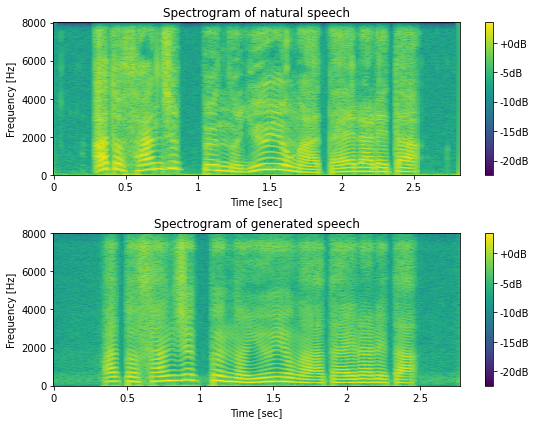

In [67]:
# 比較用に元音声の読み込み
_sr, ref_wav = wavfile.read(f"./downloads/jsut_ver1.1/basic5000/wav/{test_utt}.wav")
ref_wav = (ref_wav / 32768.0).astype(np.float64)
ref_wav = librosa.resample(ref_wav,orig_sr= _sr,target_sr= sr)

# スペクトログラムを計算
spec_ref = librosa.stft(ref_wav, n_fft=fft_size, hop_length=hop_length, window="hann")
logspec_ref = np.log(np.abs(spec_ref))
spec_gen = librosa.stft(gen_wav, n_fft=fft_size, hop_length=hop_length, window="hann")
logspec_gen = np.log(np.abs(spec_gen))

mindb = min(logspec_ref.min(), logspec_gen.min())
maxdb = max(logspec_ref.max(), logspec_gen.max())

fig, ax = plt.subplots(2, 1, figsize=(8,6))
mesh = librosa.display.specshow(logspec_ref, hop_length=hop_length, sr=sr, cmap=cmap, x_axis="time", y_axis="hz", ax=ax[0])
mesh.set_clim(mindb, maxdb)
fig.colorbar(mesh, ax=ax[0], format="%+2.fdB")

mesh = librosa.display.specshow(logspec_gen, hop_length=hop_length, sr=sr, cmap=cmap, x_axis="time", y_axis="hz", ax=ax[1])
mesh.set_clim(mindb, maxdb)
fig.colorbar(mesh, ax=ax[1], format="%+2.fdB")

for a in ax:
    a.set_xlabel("Time [sec]")
    a.set_ylabel("Frequency [Hz]")
    
ax[0].set_title("Spectrogram of natural speech")
ax[1].set_title("Spectrogram of generated speech")

plt.tight_layout()

print("自然音声")
IPython.display.display(Audio(ref_wav, rate=sr))
print("DNN音声合成")
IPython.display.display(Audio(gen_wav, rate=sr))

# 図6-13
savefig("./fig/dnntts_impl_tts_spec_comp")

### 評価データに対して音声波形生成

#### レシピのstage 5 の実行

In [ ]:
if run_sh:
    ! ./run.sh --stage 6 --stop-stage 6 --duration-model $duration_config_name --acoustic-model $acoustic_config_name \
    --tqdm $run_sh_tqdm 

## 自然音声と合成音声の比較 (bonus)

In [69]:
from pathlib import Path
from ttslearn.util import load_utt_list

with open("./downloads/jsut_ver1.1/basic5000/transcript_utf8.txt") as f:
    transcripts = {}
    for l in f:
        utt_id, script = l.split(":")
        transcripts[utt_id] = script

eval_list = load_utt_list("data/eval.list")[::-1][:5]

for utt_id in eval_list:
    # ref file
    ref_file = f"./downloads/jsut_ver1.1/basic5000/wav/{utt_id}.wav"
    _sr, ref_wav = wavfile.read(ref_file)
    ref_wav = (ref_wav / 32768.0).astype(np.float64)
    ref_wav = librosa.resample(ref_wav, orig_sr=_sr, target_sr=sr)

    gen_file = f"exp/jsut_sr16000/synthesis_{duration_config_name}_{acoustic_config_name}/eval/{utt_id}.wav"
    _sr, gen_wav = wavfile.read(gen_file)
    print(f"{utt_id}: {transcripts[utt_id]}")
    print("自然音声")
    IPython.display.display(Audio(ref_wav, rate=sr))
    print("DNN音声合成")
    IPython.display.display(Audio(gen_wav, rate=sr))

BASIC5000_5000: あと３０分の猶予が与えられた。

自然音声


DNN音声合成


BASIC5000_4999: ドナーから腎臓の提供を受ける。

自然音声


DNN音声合成


BASIC5000_4998: 村人たちは、その話を聞いて、震え上がった。

自然音声


DNN音声合成


BASIC5000_4997: その王国は、最後の王に嗣子がおらず、滅亡した。

自然音声


DNN音声合成


BASIC5000_4996: 扇型の、弧の長さを、計算で求める。

自然音声


DNN音声合成


フルコンテキストラベルではなく、漢字かな交じり文を入力としたTTSの実装は、`ttslearn.dnntts.tts` モジュールを参照してください。本章の冒頭で示した学習済みモデルを利用したTTSは、そのモジュールを利用しています。

## 学習済みモデルのパッケージング (bonus)

学習済みモデルを利用したTTSに必要なファイルをすべて単一のディレクトリにまとめます。
`ttslearn.dnntts.DNNTTS` クラスには、まとめたディレクトリを指定し、TTSを行う機能が実装されています。

### レシピの stage 99 の実行

In [ ]:
if run_sh:
    ! ./run.sh --stage 99 --stop-stage 99 --duration-model $duration_config_name --acoustic-model $acoustic_config_name

In [ ]:
!ls tts_models/jsut_sr16000_{duration_config_name}_{acoustic_config_name}

### パッケージングしたモデルを利用したTTS

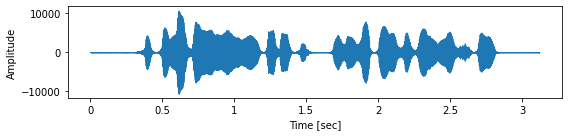

In [71]:
from ttslearn.dnntts import DNNTTS

# パッケージングしたモデルのパスを指定します
model_dir = f"./tts_models/jsut_sr16000_{duration_config_name}_{acoustic_config_name}"
engine = DNNTTS(model_dir)
wav, sr = engine.tts("ここまでお読みいただき、ありがとうございました。")

fig, ax = plt.subplots(figsize=(8, 2))
librosa.display.waveshow(wav.astype(np.float32), sr=sr, ax=ax)
ax.set_xlabel("Time [sec]")
ax.set_ylabel("Amplitude")
plt.tight_layout()

Audio(wav, rate=sr)

In [73]:
if True:
    from datetime import timedelta
    elapsed = (time.time() - start_time)
    print("所要時間:", str(timedelta(seconds=elapsed)))

所要時間: 0:10:18.325569
